In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from utils import *

In [38]:
def sliding_windows(img, win_size, stride):
    h, w = img.shape[:2]
    win_w, win_h = win_size

    for y in range(0, h - win_h, stride):
        for x in range(0, w - win_w, stride):
            yield x, y, img[y:y+win_h, x:x+win_w]

def score_patch(sat_gray, drone_gray):
    # sat_gray = cv2.cvtColor(sat_patch, cv2.COLOR_BGR2GRAY)
    # drone_gray = cv2.cvtColor(drone_img, cv2.COLOR_BGR2GRAY)
    
    MIN_INLIERS = 12
    MIN_RATIO   = 0.2
    MIN_COVERAGE = 0.05 #0.1 #0.05
    
    sift = cv2.SIFT_create(3000)
    kp_sat, desc_sat = sift.detectAndCompute(sat_gray, None)
    kp_drone, desc_drone = sift.detectAndCompute(drone_gray, None)

    if desc_sat is None or desc_drone is None:
        return None

    bf = cv2.BFMatcher(cv2.NORM_L2)
    knn = bf.knnMatch(desc_sat, desc_drone, k=2)

    good = []
    for m, n in knn:
        if m.distance < 0.85 * n.distance:
            good.append(m)

    if len(good) < MIN_INLIERS:
        return None

    pts_sat = np.float32([kp_sat[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    pts_drone = np.float32([kp_drone[m.trainIdx].pt for m in good]).reshape(-1,1,2)

    

    H, inliers = cv2.findHomography(
        pts_drone, pts_sat,
        cv2.RANSAC, 4.0
    )
    # H, inliers = cv2.estimateAffine2D(
    #     pts_drone,
    #     pts_sat,
    #     method=cv2.RANSAC,
    #     ransacReprojThreshold=6.0
    # )

    pts = pts_sat[inliers.ravel() == 1][:, 0, :]  # Nx2

    x_span = pts[:, 0].max() - pts[:, 0].min()
    y_span = pts[:, 1].max() - pts[:, 1].min()
    
    coverage = (x_span * y_span) / (sat_gray.shape[0] * sat_gray.shape[1])
    
    # if coverage < MIN_COVERAGE: return

    if H is None or inliers is None:
        return None

    # if H is not None:
    #     det = np.linalg.det(H[:2, :2])
    #     if det < 0.1 or det > 10:
    #         return #reject_patch = True

    inlier_ratio = inliers.sum() / len(inliers)

    if inlier_ratio < MIN_RATIO: return

    return {
        "kp_sat": kp_sat,
        "kp_drone": kp_drone,
        "matches": good,
        "inliers": inliers,
        "H": H,
        "score": inlier_ratio
    }

def draw_matches_inlier_outlier(
    img_sat,
    kp_sat,
    img_drone,
    kp_drone,
    matches,
    inlier_mask,
    max_matches=100
):
    """
    Draw feature matches with:
      - GREEN lines for inliers
      - RED lines for outliers

    img_sat      : satellite patch image (GRAY or BGR)
    kp_sat       : keypoints from satellite patch
    img_drone    : drone image (GRAY or BGR)
    kp_drone     : keypoints from drone image
    matches      : list of cv2.DMatch
    inlier_mask  : Nx1 or N array from cv2.findHomography
    max_matches  : limit for visualization
    """

    # --- Ensure color images ---
    if len(img_sat.shape) == 2:
        img_sat = cv2.cvtColor(img_sat, cv2.COLOR_GRAY2BGR)
    if len(img_drone.shape) == 2:
        img_drone = cv2.cvtColor(img_drone, cv2.COLOR_GRAY2BGR)

    # --- Limit matches ---
    matches = matches[:max_matches]
    inlier_mask = inlier_mask[:len(matches)].ravel()

    h1, w1 = img_sat.shape[:2]
    h2, w2 = img_drone.shape[:2]

    # --- Create side-by-side canvas ---
    canvas = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
    canvas[:h1, :w1] = img_sat
    canvas[:h2, w1:w1 + w2] = img_drone

    # --- Draw each match ---
    for m, is_inlier in zip(matches, inlier_mask):
        pt_sat = tuple(map(int, kp_sat[m.queryIdx].pt))
        pt_drone = tuple(map(int, kp_drone[m.trainIdx].pt))
        pt_drone = (pt_drone[0] + w1, pt_drone[1])  # shift x

        if is_inlier:
            color = (0, 255, 0)   # GREEN
            thickness = 2
        else:
            color = (0, 0, 255)   # RED
            thickness = 1

        cv2.line(canvas, pt_sat, pt_drone, color, thickness)
        cv2.circle(canvas, pt_sat, 4, color, -1)
        cv2.circle(canvas, pt_drone, 4, color, -1)

    return canvas

def resize_for_display(img, max_width=1600, max_height=900):
    h, w = img.shape[:2]
    scale = min(max_width / w, max_height / h, 1.0)
    new_w = int(w * scale)
    new_h = int(h * scale)
    return cv2.resize(img, (new_w, new_h))

In [39]:
results = []
# Load satellite map
sat_img, sat_transform, sat_crs = load_satellite_map("task_cv_model/map.tif")

# Load drone images
drone_imgs = load_drone_images("task_cv_model/train_data/drone_images/")

# Preprocess drone images
drone_imgs_proc = preprocess_drone_images(drone_imgs)

sat_gray = normalize_uint8(satellite_to_gray(sat_img))

name = list(drone_imgs.keys())[200]
drone_gray = drone_imgs_proc[name]

for x, y, patch in sliding_windows(
        sat_gray,
        win_size=(512, 512),
        stride=256):

    res = score_patch(patch, drone_gray)

    if res is None: continue

    score = res["inlier_ratio"]  # or inlier_ratio * coverage
    
    if score > best_score:
        best_score = score
        best_result = res
        best_result["bbox"] = (x, y, patch.shape[1], patch.shape[0])

    # visualizations = []

    # for i, r in enumerate(topK):
    #     x, y, w, h = r["bbox"]
    #     sat_patch = sat_img[y:y+h, x:x+w]
    
    #     vis = draw_matches_inlier_outlier(
    #         img_sat=sat_patch,
    #         kp_sat=r["kp_sat"],
    #         img_drone=drone_gray,
    #         kp_drone=r["kp_drone"],
    #         matches=r["matches"],
    #         inlier_mask=r["inliers"],
    #         max_matches=80
    #     )
    
    #     cv2.putText(
    #         vis,
    #         f"Rank {i+1} | Inlier ratio: {r['score']:.2f}",
    #         (10, 30),
    #         cv2.FONT_HERSHEY_SIMPLEX,
    #         0.8,
    #         (255, 255, 0),
    #         2
    #     )

    #     if accept_homography(res["H"], res["inliers"], pts_sat, patch.shape): visualizations.append(vis)
    #     visualizations.append(vis)
    
    # Existing logic (optional)
    
    # if res is None:
    #     continue

    # res["bbox"] = (x, y, 512, 512)
    # results.append(res)


In [41]:
res

In [36]:
K = 5
topK = sorted(results, key=lambda r: r["score"], reverse=True)[:K]


In [37]:
topK

[]

In [26]:
visualizations = []

for i, r in enumerate(topK):
    x, y, w, h = r["bbox"]
    sat_patch = sat_img[y:y+h, x:x+w]

    vis = draw_matches_inlier_outlier(
        img_sat=sat_patch,
        kp_sat=r["kp_sat"],
        img_drone=drone_gray,
        kp_drone=r["kp_drone"],
        matches=r["matches"],
        inlier_mask=r["inliers"],
        max_matches=80
    )

    cv2.putText(
        vis,
        f"Rank {i+1} | Inlier ratio: {r['score']:.2f}",
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.8,
        (255, 255, 0),
        2
    )

    visualizations.append(vis)
print('length of visualization:', len(visualizations))
final_vis = np.vstack(visualizations)
cv2.imwrite("match_vis_affine.png", vis)

# cv2.imshow("Top-K Sliding Window Matches", final_vis)
# cv2.waitKey(0)


length of visualization: 0


ValueError: need at least one array to concatenate

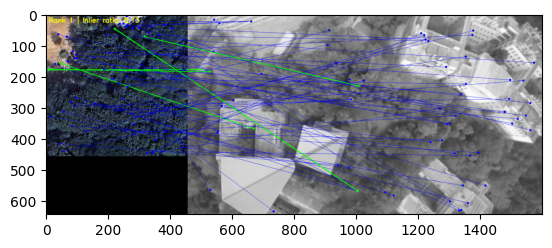

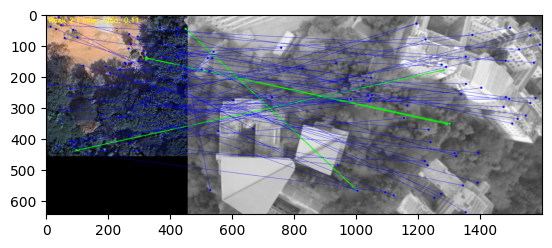

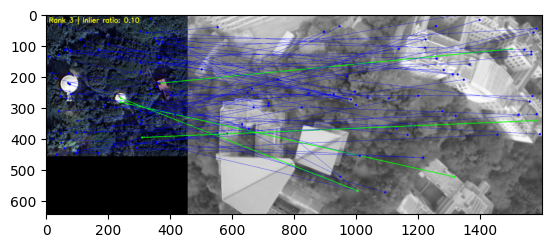

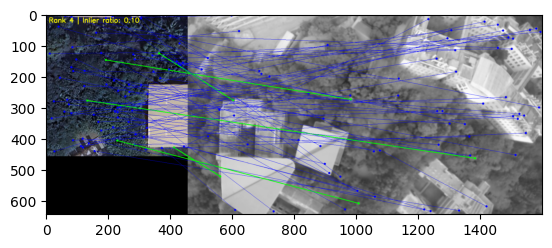

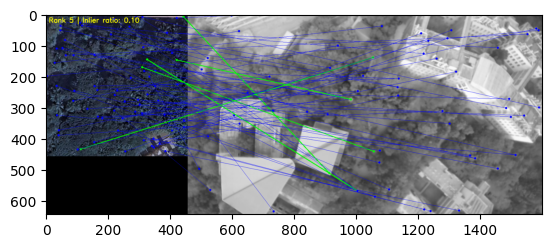

In [33]:
for vis in visualizations:
    vis_disp = resize_for_display(vis)
    plt.figure()
    plt.imshow(vis_disp)

In [2]:


def draw_matches_inlier_outlier(
    img_sat, kp_sat,
    img_drone, kp_drone,
    matches,
    inlier_mask,
    max_matches=200
):
    """
    img_sat     : satellite image (BGR or Gray)
    kp_sat      : keypoints from satellite image
    img_drone   : drone image (BGR or Gray)
    kp_drone    : keypoints from drone image
    matches     : list of cv2.DMatch
    inlier_mask : Nx1 or N boolean mask (1=inlier, 0=outlier)
    """

    # Convert to color
    if len(img_sat.shape) == 2:
        img_sat = cv2.cvtColor(img_sat, cv2.COLOR_GRAY2BGR)
    if len(img_drone.shape) == 2:
        img_drone = cv2.cvtColor(img_drone, cv2.COLOR_GRAY2BGR)

    # Limit number of matches for visualization
    matches = matches[:max_matches]
    inlier_mask = inlier_mask[:len(matches)].ravel()

    h1, w1 = img_sat.shape[:2]
    h2, w2 = img_drone.shape[:2]

    # Create canvas
    canvas = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
    canvas[:h1, :w1] = img_sat
    canvas[:h2, w1:w1 + w2] = img_drone

    # Draw matches
    for match, is_inlier in zip(matches, inlier_mask):
        pt1 = tuple(map(int, kp_sat[match.queryIdx].pt))
        pt2 = tuple(map(int, kp_drone[match.trainIdx].pt))
        pt2 = (pt2[0] + w1, pt2[1])  # shift drone image x-coord

        if is_inlier:
            color = (0, 255, 0)   # GREEN → inlier
            thickness = 2
        else:
            color = (0, 0, 255)   # RED → outlier
            thickness = 1

        cv2.line(canvas, pt1, pt2, color, thickness)
        cv2.circle(canvas, pt1, 4, color, -1)
        cv2.circle(canvas, pt2, 4, color, -1)

    return canvas


In [3]:
# Load satellite map
sat_img, sat_transform, sat_crs = load_satellite_map("task_cv_model/map.tif")

# Load drone images
drone_imgs = load_drone_images("task_cv_model/train_data/drone_images/")

# Preprocess drone images
drone_imgs_proc = preprocess_drone_images(drone_imgs)

sat_gray = normalize_uint8(satellite_to_gray(sat_img))

name = list(drone_imgs.keys())[200]
drone_gray = drone_imgs_proc[name]

In [ ]:
# im1 = cv2.cvtColor(satellite_img, cv2.COLOR_BGR2GRAY)
# im2 = cv2.cvtColor(drone_img, cv2.COLOR_BGR2GRAY)

# vis = draw_matches_inlier_outlier(
#     img_sat=im1,
#     kp_sat=kp_1,
#     img_drone=im2,
#     kp_drone=kp_2,
#     matches=good_matches,
#     inlier_mask=Inlier_matrix,
#     max_matches=100
# )

# cv2.imshow("Satellite (Left)  <->  Drone (Right)", vis)

In [4]:
def match_patch_to_drone(sat_patch, drone_img):
    sat_gray = cv2.cvtColor(sat_patch, cv2.COLOR_BGR2GRAY)
    drone_gray = cv2.cvtColor(drone_img, cv2.COLOR_BGR2GRAY)

    kp_sat, desc_sat = extract_features(sat_gray)
    kp_drone, desc_drone = extract_features(drone_gray)

    bf = cv2.BFMatcher(cv2.NORM_L2)
    knn = bf.knnMatch(desc_sat, desc_drone, k=2)

    good_matches = []
    for m, n in knn:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    if len(good_matches) < 10:
        return None

    pts_sat = np.float32([kp_sat[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
    pts_drone = np.float32([kp_drone[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)

    H, inlier_mask = cv2.findHomography(
        pts_drone, pts_sat,
        cv2.RANSAC, 4.0
    )

    return {
        "kp_sat": kp_sat,
        "kp_drone": kp_drone,
        "matches": good_matches,
        "inliers": inlier_mask,
        "H": H
    }

In [5]:
def visualize_topK_patches(
    satellite_img,
    drone_img,
    topK_patches,
    K=5
):
    visualizations = []

    for i, patch in enumerate(topK_patches[:K]):
        x0, y0, w, h = patch["bbox"]
        sat_patch = satellite_img[y0:y0+h, x0:x0+w]

        result = match_patch_to_drone(sat_patch, drone_img)
        if result is None:
            continue

        vis = draw_matches_inlier_outlier(
            img_sat=sat_patch,
            kp_sat=result["kp_sat"],
            img_drone=drone_img,
            kp_drone=result["kp_drone"],
            matches=result["matches"],
            inlier_mask=result["inliers"],
            max_matches=80
        )

        inlier_ratio = result["inliers"].sum() / len(result["inliers"])

        cv2.putText(
            vis,
            f"Rank {i+1} | Inlier ratio: {inlier_ratio:.2f}",
            (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.8,
            (255, 255, 0),
            2
        )

        visualizations.append(vis)

    return np.vstack(visualizations)

In [7]:
final_vis = visualize_topK_patches(
    sat_gray,
    drone_gray,
    topK_patches,
    K=5
)

cv2.imshow("Top-K Patch Comparison", final_vis)
# cv2.waitKey(0)

NameError: name 'topK_patches' is not defined

# Try Again

In [13]:
import cv2
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from utils import *

In [16]:
def undistort_image(img, K, dist):
    h, w = img.shape[:2]
    newK, _ = cv2.getOptimalNewCameraMatrix(K, dist, (w, h), 1)
    return cv2.undistort(img, K, dist, None, newK)
    
def rotate_by_yaw(img, yaw_deg):
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w / 2, h / 2), -yaw_deg, 1.0)
    return cv2.warpAffine(img, M, (w, h))

def extract_sift(img):
    sift = cv2.SIFT_create(nfeatures=4000)
    kp, des = sift.detectAndCompute(img, None)
    return kp, des

def integrate_yaw(timestamps, angular_z):
    yaw = np.zeros(len(angular_z))
    for i in range(1, len(angular_z)):
        dt = timestamps[i] - timestamps[i - 1]
        yaw[i] = yaw[i - 1] + angular_z[i] * dt
    return np.degrees(yaw)

def extract_patches(image, patch_size=512, stride=256):
    patches = []
    h, w = image.shape[:2]

    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            patch = image[y:y+patch_size, x:x+patch_size]
            patches.append({
                "image": patch,
                "offset": (x, y),
                # "kp": kp_patch,        # keypoints on PATCH
                # "des": des_patch
                        })
    return patches

def match_sift_des(des1, des2, ratio=0.75):
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    knn = flann.knnMatch(des1, des2, k=2)

    good = []
    for m, n in knn:
        if m.distance < ratio * n.distance:
            good.append(m)

    return good

# def affine_ransac(kp_d, kp_s, matches, thresh=6):
#     if len(matches) < 12:
#         return None, 0

#     src = np.float32([kp_d[m.queryIdx].pt for m in matches])
#     dst = np.float32([kp_s[m.trainIdx].pt for m in matches])

#     A, mask = cv2.estimateAffinePartial2D(
#         src, dst,
#         method=cv2.RANSAC,
#         ransacReprojThreshold=thresh,
#         maxIters=5000,
#         confidence=0.99
#     )

#     if mask is None:
#         return None, 0

#     return A, int(mask.sum())

def ransac_affine(kp_d, kp_s, matches, thresh=6):
    if len(matches) < 12:
        return None, None, 0

    src = np.float32([kp_d[m.queryIdx].pt for m in matches])
    dst = np.float32([kp_s[m.trainIdx].pt for m in matches])

    A, mask = cv2.estimateAffinePartial2D(
        src, dst,
        method=cv2.RANSAC,
        ransacReprojThreshold=thresh,
        maxIters=5000,
        confidence=0.99
    )

    if mask is None:
        return None, None, 0

    return A, mask.ravel().astype(bool), int(mask.sum())


def localize_drone_image(
    drone_gray,
    satellite_gray,
    K,
    dist,
    imu_yaw_deg=None,
    patch_size=512,
    stride=256,
    T_coarse=25,
    T_affine=12
):
    # --- Preprocess drone image ---
    drone_gray = undistort_image(drone_gray, K, dist)

    # if imu_yaw_deg is not None:
    #     drone_gray = rotate_by_yaw(drone_gray, imu_yaw_deg)

    kp_d, des_d = extract_sift(drone_gray)
    if des_d is None:
        return None

    # --- Extract satellite patches ---
    patches = extract_patches(satellite_gray, patch_size, stride)

    best = {
        "inliers": 0,
        "transform": None,
        "offset": None
    }

    # --- Iterate over patches ---
    for p in tqdm(patches, desc="Matching satellite patches"):
        kp_s, des_s = extract_sift(p["image"])
        if des_s is None:
            continue

        good_matches = match_sift_des(des_d, des_s)

        # --- Coarse rejection ---
        if len(good_matches) < T_coarse:
            continue

        # --- Fine geometry ---
        A, mask, inliers = ransac_affine(kp_d, kp_s, good_matches)

        if inliers < T_affine:
            continue
        affine_inlier_matches = [m for m, keep in zip(good_matches, mask) if keep]

        if inliers > best["inliers"]:
            best.update({
                "inliers": inliers,
                "transform": A,
                "offset": p["offset"],
                "kp_d": kp_d,
                "kp_s": kp_s,
                "matches": good_matches,
                'mask': mask,
                "affine_inliers": affine_inlier_matches,
                "patch": p["image"]
            })


    return best

# def extract_affine_inliers(kp_d, kp_s, matches, A, mask, thresh=6):
#     src = np.float32([kp_d[m.queryIdx].pt for m in matches])
#     dst = np.float32([kp_s[m.trainIdx].pt for m in matches])

#     src_proj = cv2.transform(src.reshape(-1,1,2), A).reshape(-1,2)
#     error = np.linalg.norm(src_proj - dst, axis=1)

#     affine_inlier_matches = [
#     m for m, keep in zip(good_matches, mask) if keep]
#     # inlier_matches = [
#     #     m for m, keep in zip(matches, mask) if keep
#     #     # m for m, e in zip(matches, mask, error) if e < thresh
#     # ]
#     return inlier_matches
def drawMatches(img1, kp1, img2, kp2, matches, inliers = None):
    # Create a new output image that concatenates the two images together
    rows1 = img1.shape[0]
    cols1 = img1.shape[1]
    rows2 = img2.shape[0]
    cols2 = img2.shape[1]

    out = np.zeros((max([rows1,rows2]),cols1+cols2,3), dtype='uint8')

    # Place the first image to the left
    out[:rows1,:cols1,:] = np.dstack([img1, img1, img1])

    # Place the next image to the right of it
    out[:rows2,cols1:cols1+cols2,:] = np.dstack([img2, img2, img2])

    # For each pair of points we have between both images
    # draw circles, then connect a line between them
    for mat in matches:

        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # x - columns, y - rows
        (x1,y1) = kp1[img1_idx].pt
        (x2,y2) = kp2[img2_idx].pt

        inlier = False

        if inliers is not None:
            for i in inliers:
                if i.item(0) == x1 and i.item(1) == y1 and i.item(2) == x2 and i.item(3) == y2:
                    inlier = True

        # Draw a small circle at both co-ordinates
        cv2.circle(out, (int(x1),int(y1)), 4, (255, 0, 0), 1)
        cv2.circle(out, (int(x2)+cols1,int(y2)), 4, (255, 0, 0), 1)

        # Draw a line in between the two points, draw inliers if we have them
        if inliers is not None and inlier:
            cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (0, 255, 0), 1) #### inlier lines
        elif inliers is not None:
            cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (0, 0, 255), 1)

        if inliers is None:
            cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (255, 0, 0), 1) ####if theree is no inliers

    return out


In [10]:
K = np.array([
    [456.46871015134053, 0.0, 643.3599454303429],
    [0.0, 455.40127946882507, 357.51076963739786],
    [0.0, 0.0, 1.0]
])

dist = np.array([
    0.03299031731836506,
   -0.03150792611905064,
   -0.0017902177017069096,
    0.00027220443810142304,
    0.0
])


In [11]:
# Load satellite map
sat_img, sat_transform, sat_crs = load_satellite_map("task_cv_model/map.tif")

# Load drone images
drone_imgs = load_drone_images("task_cv_model/train_data/drone_images/")

# Preprocess drone images
drone_imgs_proc = preprocess_drone_images(drone_imgs)

sat_gray = normalize_uint8(satellite_to_gray(sat_img))

name = list(drone_imgs.keys())[200]
drone_gray = drone_imgs_proc[name]

# print('shape:', sat_gray.shape, drone_gray.shape)
best_match = localize_drone_image(
    drone_gray,
    sat_gray,
    K=K,
    dist=dist
    # imu_yaw_deg=32.0
)

if best_match is not None:
    print("Best inliers:", best_match["inliers"])
    print("Satellite offset:", best_match["offset"])
else:
    print("Localization failed")

shape: (6912, 6912) (720, 1280)


Matching satellite patches: 100%|█████████████| 676/676 [01:25<00:00,  7.89it/s]

Best inliers: 50
Satellite offset: (1536, 3328)


Visualizing inliers: 50
Drone kp example: (509.51715087890625, 320.1578063964844)
Sat kp example: (173.07461547851562, 503.0903625488281)
Patch shape: (512, 512)


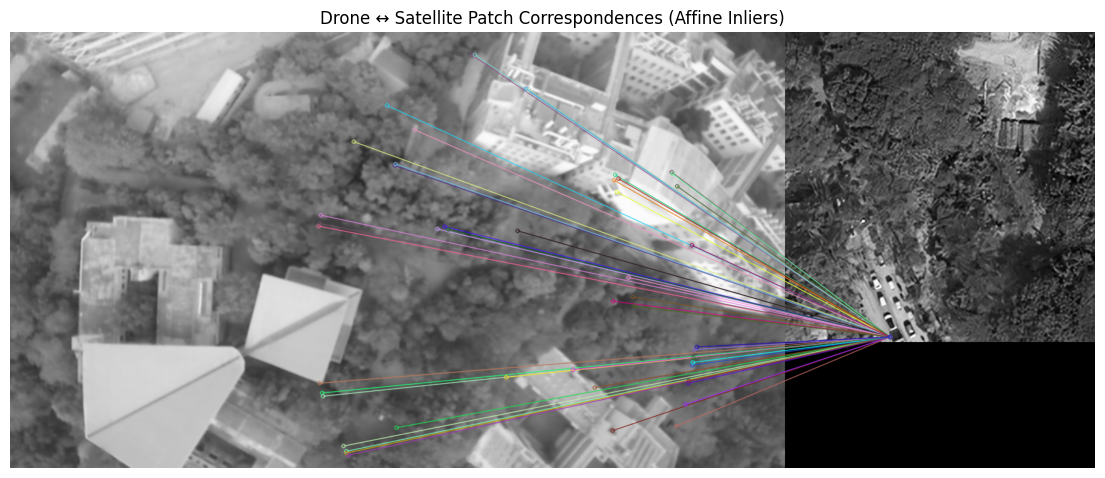

In [14]:
kp_d = best_match["kp_d"]
kp_s = best_match["kp_s"]
# matches = best_match["matches"]
patch = best_match["patch"]
A = best_match["transform"]
# mask = best_match['mask']

# Extract affine inliers
# inlier_matches = extract_affine_inliers(
#     kp_d, kp_s, matches, A, mask
# )
inlier_matches = best_match["affine_inliers"]

print("Visualizing inliers:", len(inlier_matches))
print("Drone kp example:", best_match["kp_d"][inlier_matches[0].queryIdx].pt)
print("Sat kp example:", best_match["kp_s"][inlier_matches[0].trainIdx].pt)
print("Patch shape:", best_match["patch"].shape)

vis = cv2.drawMatches(
    drone_gray, kp_d,
    patch, kp_s,
    inlier_matches,
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)
os.makedirs('Output_affine', exist_ok = True)

plt.figure(figsize=(14,6))
plt.imshow(vis, cmap="gray")
plt.title("Drone ↔ Satellite Patch Correspondences (Affine Inliers)")
plt.axis("off")
# plt.savefig("Output_affine/best_inlier_match_affine.png")
plt.show()

In [ ]:
def localize_drone_image(
    drone_gray,
    satellite_gray,
    K,
    dist,
    imu_yaw_deg=None,
    patch_size=512,
    stride=256,
    T_coarse=25,
    T_affine=12
):
    # --- Preprocess drone image ---
    drone_gray = undistort_image(drone_gray, K, dist)

    # if imu_yaw_deg is not None:
    #     drone_gray = rotate_by_yaw(drone_gray, imu_yaw_deg)

    kp_d, des_d = extract_sift(drone_gray)
    if des_d is None:
        return None

    # --- Extract satellite patches ---
    patches = extract_patches(satellite_gray, patch_size, stride)

    best = {
        "inliers": 0,
        "transform": None,
        "offset": None
    }

    # --- Iterate over patches ---
    for p in tqdm(patches, desc="Matching satellite patches"):
        kp_s, des_s = extract_sift(p["image"])
        if des_s is None:
            continue

        good_matches = match_sift_des(des_d, des_s)

        # --- Coarse rejection ---
        if len(good_matches) < T_coarse:
            continue

        # --- Fine geometry ---
        A, mask, inliers = ransac_affine(kp_d, kp_s, good_matches)

        if inliers < T_affine:
            continue
        affine_inlier_matches = [m for m, keep in zip(good_matches, mask) if keep]

        if inliers > best["inliers"]:
            best.update({
                "inliers": inliers,
                "transform": A,
                "offset": p["offset"],
                "kp_d": kp_d,
                "kp_s": kp_s,
                "matches": good_matches,
                'mask': mask,
                "affine_inliers": affine_inlier_matches,
                "patch": p["image"]
            })


    return best


In [ ]:
# Load satellite map
sat_img, sat_transform, sat_crs = load_satellite_map("task_cv_model/map.tif")

# Load drone images
drone_imgs = load_drone_images("task_cv_model/train_data/drone_images/")

# Preprocess drone images
drone_imgs_proc = preprocess_drone_images(drone_imgs)

sat_gray = normalize_uint8(satellite_to_gray(sat_img))

name = list(drone_imgs.keys())[200]
drone_gray = drone_imgs_proc[name]

# print('shape:', sat_gray.shape, drone_gray.shape)
best_match = localize_drone_image(
    drone_gray,
    sat_gray,
    K=K,
    dist=dist
    # imu_yaw_deg=32.0
)

if best_match is not None:
    print("Best inliers:", best_match["inliers"])
    print("Satellite offset:", best_match["offset"])
else:
    print("Localization failed")

In [17]:
def plot_imgs(img1, img2):
  fig, ax = plt.subplots(1, 2, figsize=(15, 20))
  for a in ax:
    a.set_axis_off()
  ax[0].imshow(img1,cmap='gray')
  ax[1].imshow(img2,cmap='gray')

In [18]:
drone_gray = undistort_image(drone_gray, K, dist)

# if imu_yaw_deg is not None:
#     drone_gray = rotate_by_yaw(drone_gray, imu_yaw_deg)

kp_d, des_d = extract_sift(drone_gray)
if des_d is None:
    return None

# --- Extract satellite patches ---
patches = extract_patches(satellite_gray, patch_size, stride)

best = {
    "inliers": 0,
    "transform": None,
    "offset": None
}

# --- Iterate over patches ---
for p in tqdm(patches, desc="Matching satellite patches"):
    kp_s, des_s = extract_sift(p["image"])
    if des_s is None:
        continue

    kp_img1 = cv2.drawKeypoints(drone_gray, kp_d, None, color=(0,255,0), flags=0)
    kp_img2 = cv2.drawKeypoints(p["image"], kp_s, None, color=(0,255,0), flags=0)
    
    print('keypoints for image1 and image2...')
    plot_imgs(kp_img1, kp_img2)

    # good_matches = match_sift_des(des_d, des_s)

    # # --- Coarse rejection ---
    # if len(good_matches) < T_coarse:
    #     continue

    # # --- Fine geometry ---
    # A, mask, inliers = ransac_affine(kp_d, kp_s, good_matches)

    # if inliers < T_affine:
    #     continue
    # affine_inlier_matches = [m for m, keep in zip(good_matches, mask) if keep]

    # if inliers > best["inliers"]:
    #     best.update({
    #         "inliers": inliers,
    #         "transform": A,
    #         "offset": p["offset"],
    #         "kp_d": kp_d,
    #         "kp_s": kp_s,
    #         "matches": good_matches,
    #         'mask': mask,
    #         "affine_inliers": affine_inlier_matches,
    #         "patch": p["image"]
    #     })
    break

SyntaxError: 'return' outside function (3078432868.py, line 8)

# Affine +Homography

# Integrate homography cleanly into your full pipeline

In [20]:
import cv2
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [21]:
def undistort_image(img, K, dist):
    h, w = img.shape[:2]
    newK, _ = cv2.getOptimalNewCameraMatrix(K, dist, (w, h), 1)
    return cv2.undistort(img, K, dist, None, newK)

def extract_patches(image, patch_size=512, stride=256):
    patches = []
    h, w = image.shape[:2]

    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            patch = image[y:y+patch_size, x:x+patch_size]
            patches.append({
                "image": patch,
                "offset": (x, y)
            })
    return patches

def match_sift_descriptors(des1, des2, ratio=0.75):
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    knn = flann.knnMatch(des1, des2, k=2)

    good = []
    for m, n in knn:
        if m.distance < ratio * n.distance:
            good.append(m)
    return good

def affine_ransac(kp_d, kp_s, matches, thresh=6):
    if len(matches) < 12:
        return None, None

    src = np.float32([kp_d[m.queryIdx].pt for m in matches])
    dst = np.float32([kp_s[m.trainIdx].pt for m in matches])

    A, mask = cv2.estimateAffinePartial2D(
        src, dst,
        method=cv2.RANSAC,
        ransacReprojThreshold=thresh,
        maxIters=5000,
        confidence=0.99
    )

    if mask is None:
        return None, None

    inlier_matches = [
        m for m, keep in zip(matches, mask.ravel()) if keep
    ]

    return A, inlier_matches

def affine_ransac(kp_d, kp_s, matches, thresh=6):
    if len(matches) < 12:
        return None, None

    src = np.float32([kp_d[m.queryIdx].pt for m in matches])
    dst = np.float32([kp_s[m.trainIdx].pt for m in matches])

    A, mask = cv2.estimateAffinePartial2D(
        src, dst,
        method=cv2.RANSAC,
        ransacReprojThreshold=thresh,
        maxIters=5000,
        confidence=0.99
    )

    if mask is None:
        return None, None

    inlier_matches = [
        m for m, keep in zip(matches, mask.ravel()) if keep
    ]

    return A, inlier_matches

def localize_drone_image(
    drone_gray,
    satellite_gray,
    K,
    dist,
    imu_yaw_deg=None,
    patch_size=512,
    stride=256,
    T_coarse=25,
    T_affine=12,
    T_homography=15
):
    # --- Drone preprocessing ---
    drone_gray = undistort_image(drone_gray, K, dist)

    if imu_yaw_deg is not None:
        drone_gray = rotate_by_yaw(drone_gray, imu_yaw_deg)

    kp_d, des_d = extract_sift(drone_gray)
    if des_d is None:
        return None

    patches = extract_patches(satellite_gray, patch_size, stride)

    best_match = {
        "score": 0
    }

    # --- Search over patches ---
    for p in tqdm(patches, desc="Matching satellite patches"):
        kp_s, des_s = extract_sift(p["image"])
        if des_s is None:
            continue

        good_matches = match_sift_descriptors(des_d, des_s)

        if len(good_matches) < T_coarse:
            continue

        # --- Affine verification ---
        A, affine_inliers = affine_ransac(kp_d, kp_s, good_matches)
        if A is None or len(affine_inliers) < T_affine:
            continue

        # Reject degenerate affine scales
        sx = np.linalg.norm(A[0, :2])
        sy = np.linalg.norm(A[1, :2])
        if not (0.3 < sx < 3.0 and 0.3 < sy < 3.0):
            continue

        # --- Homography refinement ---
        H, H_inliers = homography_ransac(kp_d, kp_s, affine_inliers)

        if len(H_inliers) < T_homography:
            continue

        # --- Keep best ---
        if len(H_inliers) > best_match["score"]:
            best_match = {
                "score": len(H_inliers),
                "kp_d": kp_d,
                "kp_s": kp_s,
                "patch": p["image"],
                "offset": p["offset"],
                "affine_A": A,
                "H": H,
                "matches": H_inliers
            }

    return best_match if best_match.get("score", 0) > 0 else None

def visualize_best_match(drone_gray, best_match, save_path=None):
    vis = cv2.drawMatches(
        drone_gray, best_match["kp_d"],
        best_match["patch"], best_match["kp_s"],
        best_match["matches"],
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    plt.figure(figsize=(14,6))
    plt.imshow(vis, cmap="gray")
    plt.title(f"Drone ↔ Satellite Patch (Homography Inliers = {len(best_match['matches'])})")
    plt.axis("off")

    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()


In [24]:
K = np.array([
    [456.46871015134053, 0.0, 643.3599454303429],
    [0.0, 455.40127946882507, 357.51076963739786],
    [0.0, 0.0, 1.0]
])

dist = np.array([
    0.03299031731836506,
   -0.03150792611905064,
   -0.0017902177017069096,
    0.00027220443810142304,
    0.0
])


In [25]:
# Load satellite map
sat_img, sat_transform, sat_crs = load_satellite_map("task_cv_model/map.tif")

# Load drone images
drone_imgs = load_drone_images("task_cv_model/train_data/drone_images/")

# Preprocess drone images
drone_imgs_proc = preprocess_drone_images(drone_imgs)

sat_gray = normalize_uint8(satellite_to_gray(sat_img))

name = list(drone_imgs.keys())[200]
drone_gray = drone_imgs_proc[name]

best_match = localize_drone_image(
    drone_gray,
    sat_gray,
    K=K,
    dist=dist
)

# if best_match is None:
#     print("Localization failed")
# else:
#     print("Homography inliers:", best_match["score"])
#     print("Satellite offset:", best_match["offset"])

#     visualize_best_match(
#         drone_gray,
#         best_match,
#         save_path="Output_homo/best_homography_match.png"
#     )


Matching satellite patches: 100%|█████████████| 676/676 [01:13<00:00,  9.21it/s]
